# CS 109A/AC 209A/STAT 121A Data Science: Airbnb Project
## Final Report
**Harvard University**  
**Fall 2016**  
**Team**: Stephen Camera-Murray, Himani Garg, and Vijay Thangella  
**TF**: Christine Hwang  
  
**Due Date: ** Monday, November 28th, 2016 at 11:59pm

### Initial Setup

#### Import libraries

In [2]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from sklearn.linear_model import LogisticRegression

# suppress warnings
warnings.filterwarnings ( 'ignore' )
%matplotlib inline

#### Load the cleansed data

We begin by loading the listings dataset we saved after cleansing from milestone #3:  
- cleansed_listings_with_target.csv.gz - the New York City Airbnb listing data from January 2015 (cleansed with target)  
  
**Note** - The baseline model is ignoring seasonality for now. If we can later determine that seasonality plays a large enough part in price prediction, we'll include it in our final model.

In [4]:
# load listings data into a pandas df
listingsDF = pd.read_csv (  './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', compression = 'gzip' )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
0,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
1,Apartment 20 Minutes Times Square,Hamilton Heights,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,NaN,...,8.0,9.0,8.0,7.0,8.0,2,31,12,1,Low


In [3]:
print ( 'The listings dataframe has {0} listings and {1} columns.' ).format ( listingsDF.shape [ 0 ], listingsDF.shape [ 1 ] )

The listings dataframe has 27392 listings and 30 columns.


The cleansed listings dataframe is the main dataset we'll be using for our baseline prediction. It has 12,591 listings and 31 columns. The columns are listed below.

In [4]:
print listingsDF.columns.values

['name' 'neighborhood' 'property_type' 'room_type' 'accommodates'
 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'square_feet' 'price'
 'guests_included' 'minimum_nights' 'maximum_nights' 'availability_30'
 'availability_60' 'availability_90' 'availability_365' 'number_of_reviews'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'host_listing_count' 'months_as_host'
 'months_since_first_review' 'months_since_last_review']


Keeping in mind that our goal is to provide pricing guidance to new owners who wish to list their property, we've come up with three price groupings based on our data to have a nice balance between the groups **and** user-friendly ranges. As we can see from the distribution below (filtering out the handful of \$1000+ listings to improve the visualization) for one bedroom listings, there's a wide range. We'll create a new target variable to identify each listing for one of three categories:  
- Low: Up to \$130  
- Mid: \$130 - \$350  
- High: Over \$350  
  
**Note**: The distribution is different than in milestone #3. We discovered an error we made on the price column while cleansing the data and have since corrected it. Our price ranges have been updated as well.

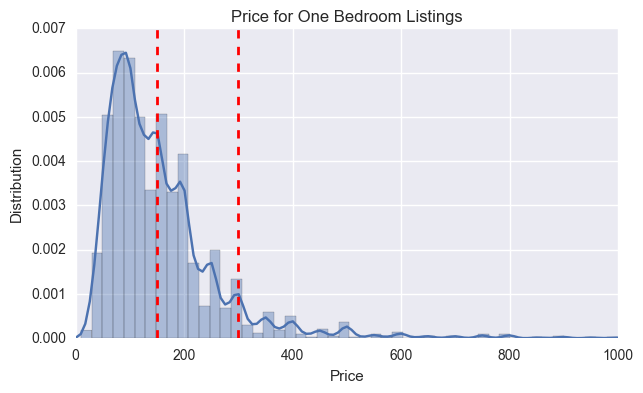

In [5]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 7, 4 ) } )

# plot the histogram of prices - filtering out the extreme highs
ax = sns.distplot ( listingsDF [ "price" ] [ listingsDF [ "price" ] < 1000 ] )

# set the labels
ax.set_title  ( "Price for One Bedroom Listings" )
ax.set_xlabel ( "Price" )
ax.set_ylabel ( "Distribution" )

ax.set_xlim ( 0, 1000 )

# set our price grouping cutoffs
plt.axvline ( 150, color = 'r', linestyle = 'dashed', linewidth = 2 )
plt.axvline ( 300, color = 'r', linestyle = 'dashed', linewidth = 2 )

# display the visualization
plt.show()

Now, let's create a price category column and drop the price column.

In [6]:
# create the price_category column based on our ranges
listingsDF [ "price_category" ] = "Low"
listingsDF [ "price_category" ][ ( listingsDF [ "price" ] >= 150 ) & ( listingsDF [ "price" ] <= 300 ) ] = "Mid"
listingsDF [ "price_category" ][ ( listingsDF [ "price" ] >  300 ) ] = "High"

# drop the price column
listingsDF.drop ( [ 'price' ], axis = 1, inplace = True )

# display the first two rows
listingsDF.head ( n = 2 )

,name,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,Stay like a real New Yorker!,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
1846722,Apartment 20 Minutes Times Square,Hamilton Heights,Apartment,Entire home/apt,10,1.0,3.0,3.0,Real Bed,NaN,...,8.0,9.0,8.0,7.0,8.0,2,31,12,1,Low


Now let's see what the distribution is among the price categories.

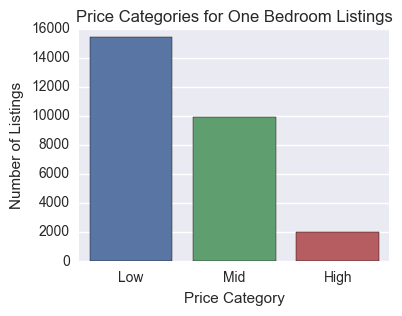

In [87]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 4, 3 ) } )
ax = plt.axes()

# create a barplot of the price categories
ax = sns.barplot ( x = listingsDF.price_category.value_counts().index
                 , y = listingsDF.price_category.value_counts() )

# set the labels
ax.set_title  ( "Price Categories for One Bedroom Listings" )
ax.set_xlabel ( "Price Category" )
ax.set_ylabel ( "Number of Listings" )

# display the visualization
plt.show()

Save the new dataset.

In [8]:
# save the listings dataframe as a tab-delimited, compressed file
listingsDF.to_csv ( './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', index = False, compression = 'gzip' )

Split our dataframe into train and test and separate our predictors from the target.

In [9]:
# split our dataframe into train and test
train, test = train_test_split ( listingsDF, train_size = 0.6 )

# separate x's and y's
x_train = train.drop ( "price_category", axis = 1 )
x_test  = test.drop  ( "price_category", axis = 1 )
y_train = train [ "price_category" ]
y_test  = test  [ "price_category" ]

#### Establishing a baseline model  
  
Before we begin model building, we need to establish a baseline model to compare against our final model. Our goal is to provide pricing guidance to new owners who wish to list their property, we come up with three price groupings based on our data to have a nice balance between the groups and user-friendly ranges.  
  
We'll use the following models for our baselines:
- Random selection
- Low model (choose "Low" category only)
- Mid model (choose "Mid" category only)
- High model (choose "High" category only)  

These models will be applied to our testing dataset. But first, let's look at the proportion of listings in the test set that fall in to each price category.

In [10]:
# fetch the number of listings in the test dataset
num_listings = y_test.shape [ 0 ]

# print the price category percentages
print ( 'Percentage of listings with the price category Low: {0:.1f}%, Mid: {1:.1f}%, High: {2:.1f}%' ).format ( 100.0 * y_test.value_counts() [ 0 ] / num_listings, 100.0 * y_test.value_counts() [ 1 ] / num_listings, 100.0 * y_test.value_counts() [ 2 ] / num_listings )

Percentage of listings with the price category Low: 56.1%, Mid: 36.8%, High: 7.1%


Create a function to score our models.

In [11]:
# function to compute the accuracy of a given model
score = lambda model, x_test, y_test: pd.Series ( [ model.score ( x_test, y_test ), 
                                                    model.score ( x_test [ y_test == "Low" ],  y_test [ y_test == "Low" ]  ),
                                                    model.score ( x_test [ y_test == "Mid" ],  y_test [ y_test == "Mid" ]  ),
                                                    model.score ( x_test [ y_test == "High" ], y_test [ y_test == "High" ] ),
                                                    f1_score    ( y_test, model.predict ( x_test ), average = "weighted" ) ],
                                                    index = [ 'Overall Accuracy', 'Accuracy on Low Category', 'Accuracy on Mid Category', 'Accuracy on High Category', 'F1 Score'  ])

Create functions for our baseline models.

In [12]:
# model predicting random values
class random_model ( object ):
    def predict ( self, x ):
        cats = [ "Low", "Mid", "High" ]
        return np.random.choice ( cats, len ( x ), replace = True )

    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting Low
class low_model ( object ):
    def predict ( self, x ):
        return np.array ( [ "Low" ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting Mid
class mid_model ( object ):
    def predict ( self, x ):
        return np.array ( [ "Mid" ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting High
class high_model ( object ):
    def predict ( self, x ):
        return np.array ( [ "High" ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

Build our models and score.

In [70]:
# build and score our baseline models
random              = random_model()
random_model_scores = score ( random, x_test, y_test )

low                 = low_model()
low_model_scores    = score ( low, x_test, y_test )

mid                 = mid_model()
mid_model_scores    = score ( mid, x_test, y_test )

high                = high_model()
high_model_scores   = score ( high, x_test, y_test )

# print scores
scoreDF = pd.DataFrame ( { 'Random Model'              : random_model_scores,
                           'Low Model'                 : low_model_scores,
                           'Mid Model'                 : mid_model_scores,
                           'High Model'                : high_model_scores } )
scoreDF

,High Model,Low Model,Mid Model,Random Model
Overall Accuracy,0.071279,0.560646,0.368075,0.330565
Accuracy on Low Category,0.000000,1.000000,0.000000,0.322969
Accuracy on Mid Category,0.000000,0.000000,1.000000,0.331019
Accuracy on High Category,1.000000,0.000000,0.000000,0.361076
F1 Score,0.009485,0.402813,0.198058,0.373569


#### Summary

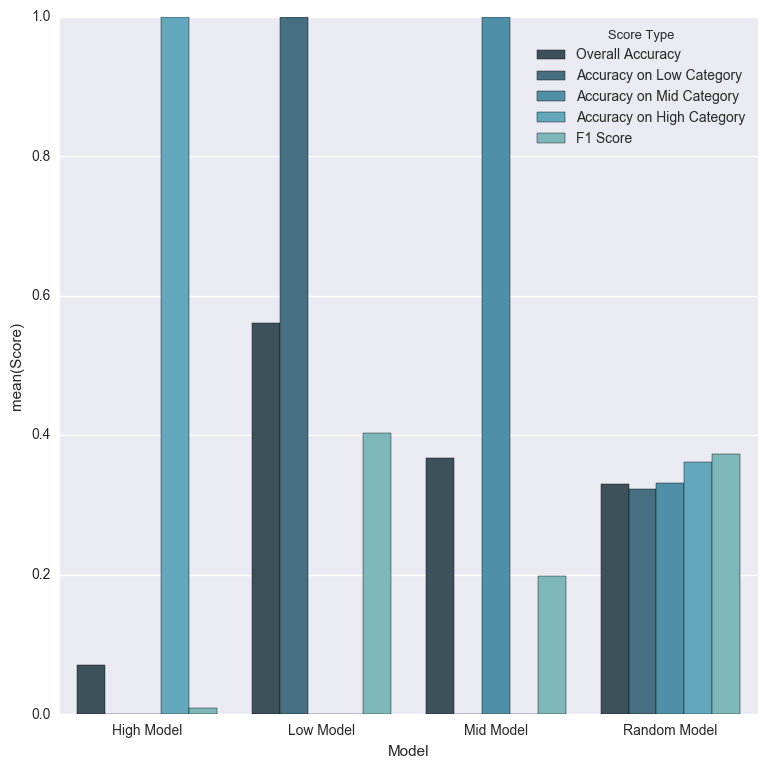

In [88]:
# set up visualization
sns.set ( rc = { "figure.figsize" : ( 9, 9 ) } )
sns.set_palette ( palette = "GnBu_d" )
ax = plt.axes()

# create a barplot of the price categories
#ax = sns.barplot ( x = list(scoreDF.columns.values), y = scoreDF.values, hue = scoreDF.index.value_counts().index )
q = pd.concat ( [ pd.DataFrame ( { "Score Type": np.tile ( scoreDF.index.values, 4 ) } ), pd.melt ( scoreDF, var_name = "Model", value_name = "Score" ) ], axis = 1 )
ax = sns.barplot ( x = "Model", y = "Score", hue = "Score Type", data = q )